# RSA Simple Power Analysis on Arduino

## Import relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from math import factorial
import numpy as np
import scipy.io
import scipy.signal
import sys

## Import traces from the oscilloscope
- Clean up the data if needed
- Extract only relevant columns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Timing Trace
df_timing = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Applied Crypto Project/Project_Code/F0000CH1.CSV')
df_timing_clean = df_timing[['Time', 'Voltage']]

# Power Trace
df_power_trace = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Applied Crypto Project/Project_Code/F0000CH2.CSV')
df_power_trace_clean = df_power_trace[['Time', 'Voltage']]

## Plotting of the graph
- Pass the power trace through a filter first to smoothen out the trace
- Plot the graph of:
    - Power trace
    - Timing trace (for each cycle of modular exponentiation

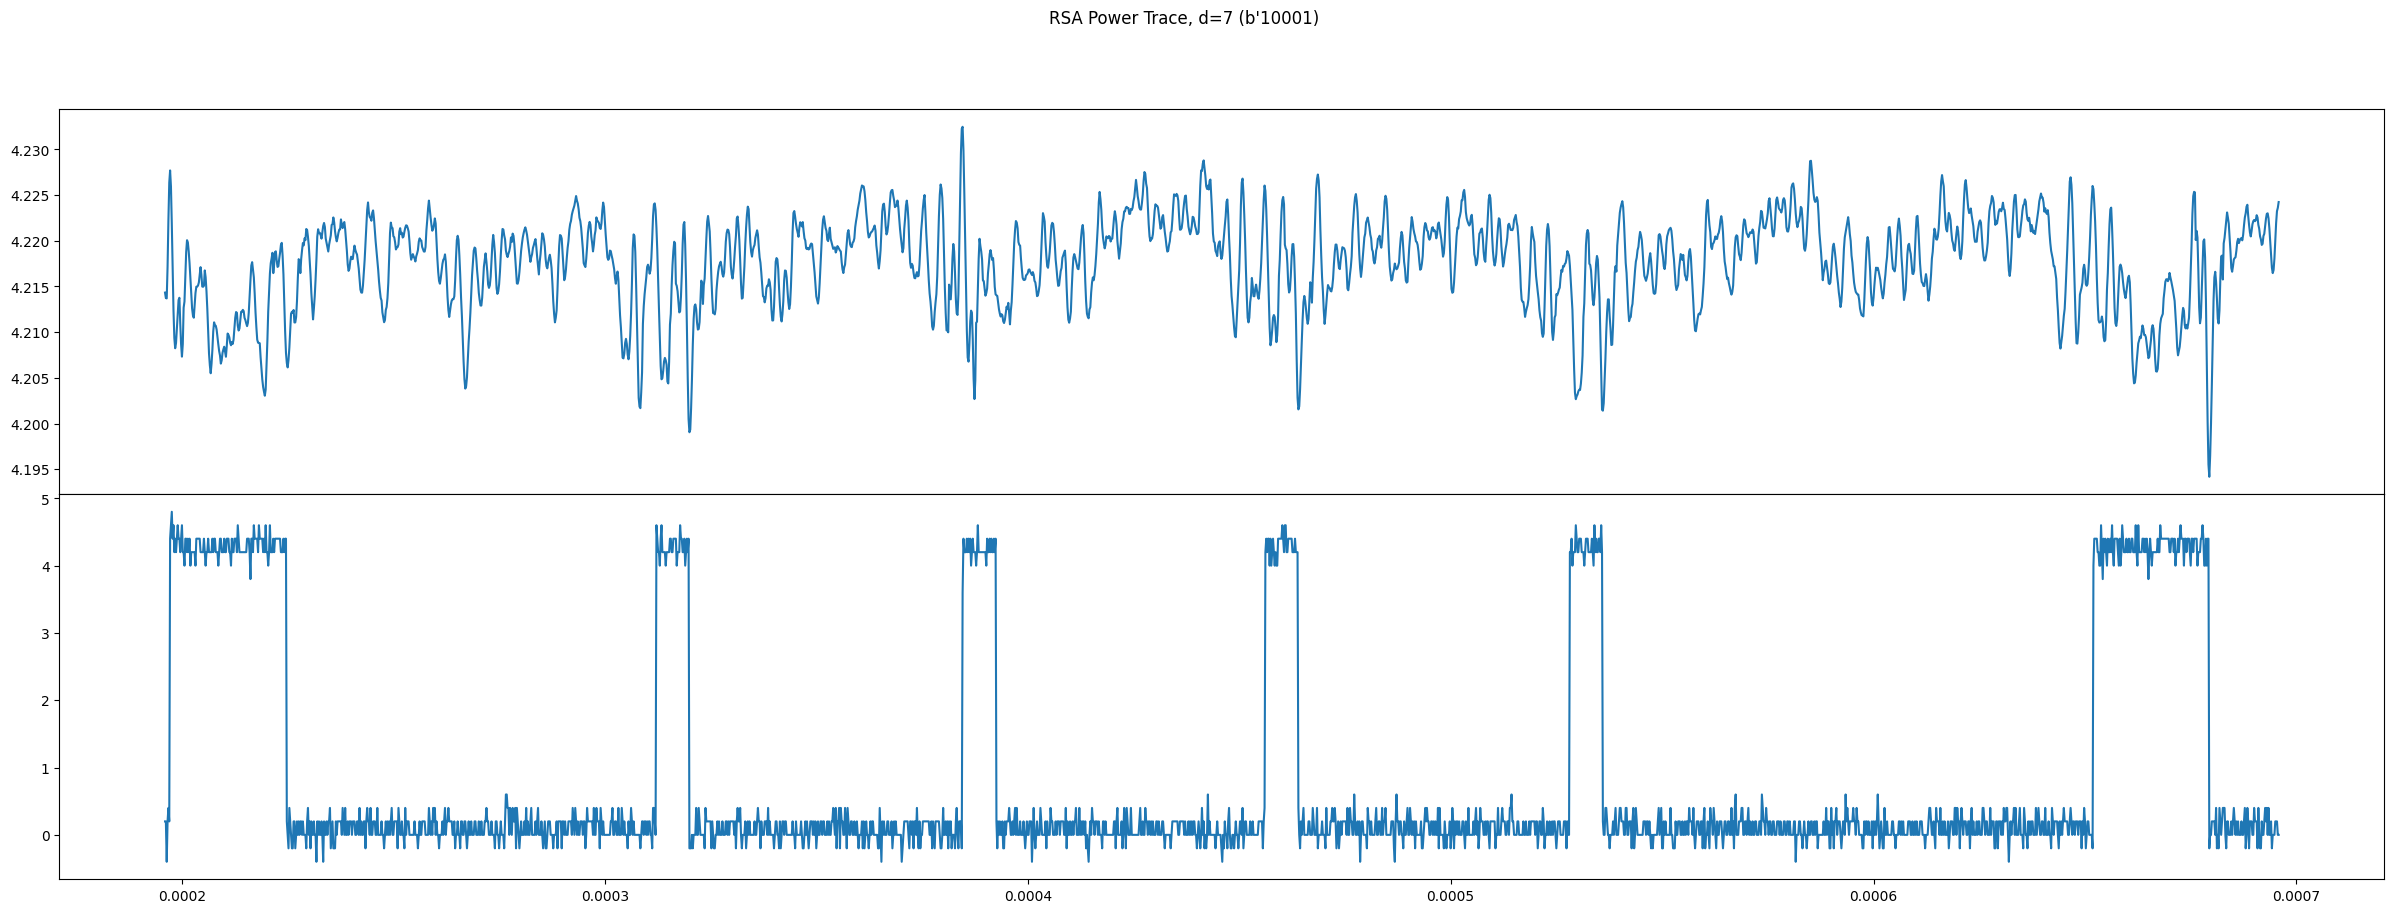

In [4]:
df_timing_time = df_timing_clean['Time']
df_timing_voltage = df_timing_clean['Voltage']


df_power_trace_time = df_power_trace_clean['Time']
df_power_trace_voltage_filtered = scipy.signal.savgol_filter(df_power_trace_clean['Voltage'], 35, 10)

# Plotting the graph, sharing an x-axis
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
fig.suptitle('RSA Power Trace, d=7 (b\'10001)')
axs[0].plot(df_power_trace_time , df_power_trace_voltage_filtered)
axs[1].plot(df_timing_time, df_timing_voltage)


## Observe the graph
- Notice that:
    1. Trace for bit 1 is longer than bit 0
    2. Bit 1 has a longer trace and resembles a "m" shape
    3. Bit 0 has a short trace and resembles a 'n' shape
    4. At the end of every modular expodentiation cycle, there will be a dip in voltage.
    5. Dip in voltage for bit 1 occurs early before a second dip
-
- We can make use of 4) to separate each segment corresponding to a bit
- We can use 2) and 3) to differentiate between bits 1 and 0
- Although 5) might be an issue, we can resolve it by using a minimum threshold
    - Time taken for Bit 0 to drop in voltage >> Time taken for Bit 1's first dip in voltage
    - We can use a minimum threshold to prevent misclassification.

## Processing the data

### Sort the data and identify the lowest voltage used
- For this section, we identified the lowest 20 points to have a rough gauge on the variance between the dips in voltage.
- 20 is because I looked at the graph and counted approximately how many dips in voltage there are (closest to the lowest voltage)
- We can see that the variance is around 0.008 to 0.009.
    - 0.009 was selected cuz it gave better readings

In [5]:
arr = np.array(df_power_trace_voltage_filtered)
arr = np.sort(arr)
arr[0:20]

array([4.19417259, 4.19551908, 4.19646199, 4.19904245, 4.19933399,
       4.19995815, 4.20014501, 4.20047845, 4.20140679, 4.20151405,
       4.20154431, 4.20168005, 4.20169547, 4.20184881, 4.20188061,
       4.20222838, 4.20266181, 4.20267577, 4.20280596, 4.20282274])

## Code
- Iterate over all the points in the power trace
- If its below the min threshold voltage, check if it has crossed the threshold limit.
- If both conditions are satisfied, the segment has completed and append it to the signature array. Assign i to start and continue iteration

### Variables
- minvalue - Threshold voltage to separate each segment corresponding to a bit
- signatures - An array to contain the segment of points representing a bit
- limit - Minimum threshold determining how many points should minimally be in a segment (bit 0)
- start -  A variable keeping track of the first point of the segment


In [6]:
minvalue = 4.19417259 + 0.009

signatures = []

limit = 300

first = 0;
start = first;
for i in range(1, len(df_power_trace_voltage_filtered)):

    #Check if point is below threshold voltage
    if df_power_trace_voltage_filtered[i] < minvalue:

        # Check if the no. of points so far has exceeded the minimum threshold
        if i - start < limit:
            continue

        signatures.append(df_power_trace_voltage_filtered[start : i])
        start = i

### Check the signature array
- Check each element in the array for its length.
- This tells us how many points there are in each segment, representing a bit
- Longer traces will correspond to bit 1, shorter traces will correspond to bit 0.
    - Other implementations make use of Otsu thresholding algo to optimize this class variance
    - In our case, we can clearly see the difference in lengths of trace and we will use 420 as the threshold

### Reconstruct the decryption key
- For each element in the signatures array:
    1. Logical shift left the decryption key variable by 1
    2. Check the length of the signatures element
        - If its more than the threshold, its a bit 1. OR the last bit of the decryption key by 1.
        - If its less than the threshold, its a bit 0. No further operations needed since shifting by left by default shifts in a 0

In [7]:
decryption_key = 0
threshold = 420 #threshold to determine bit 0 or 1

for i in range(len(signatures)):
    print(len(signatures[i]))

    decryption_key = decryption_key << 1
    if (len(signatures[i]) > threshold):
        decryption_key = decryption_key | 1

print(f"Decryption key: {decryption_key}")

560
397
382
329
747
Decryption key: 17


## Processing another trace, where d = 277

In [8]:
# Power Trace
df_power_trace = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Applied Crypto Project/Project_Code/d_is_277_CH1.CSV')
df_power_trace_clean = df_power_trace[['Time', 'Voltage']]

df_timing_trace = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Applied Crypto Project/Project_Code/d_is_277_CH2.CSV')
df_timing_trace_clean = df_timing_trace[['Time', 'Voltage']]

For this dataset, we also did some cleaning up to include only 1 cycle of RSA

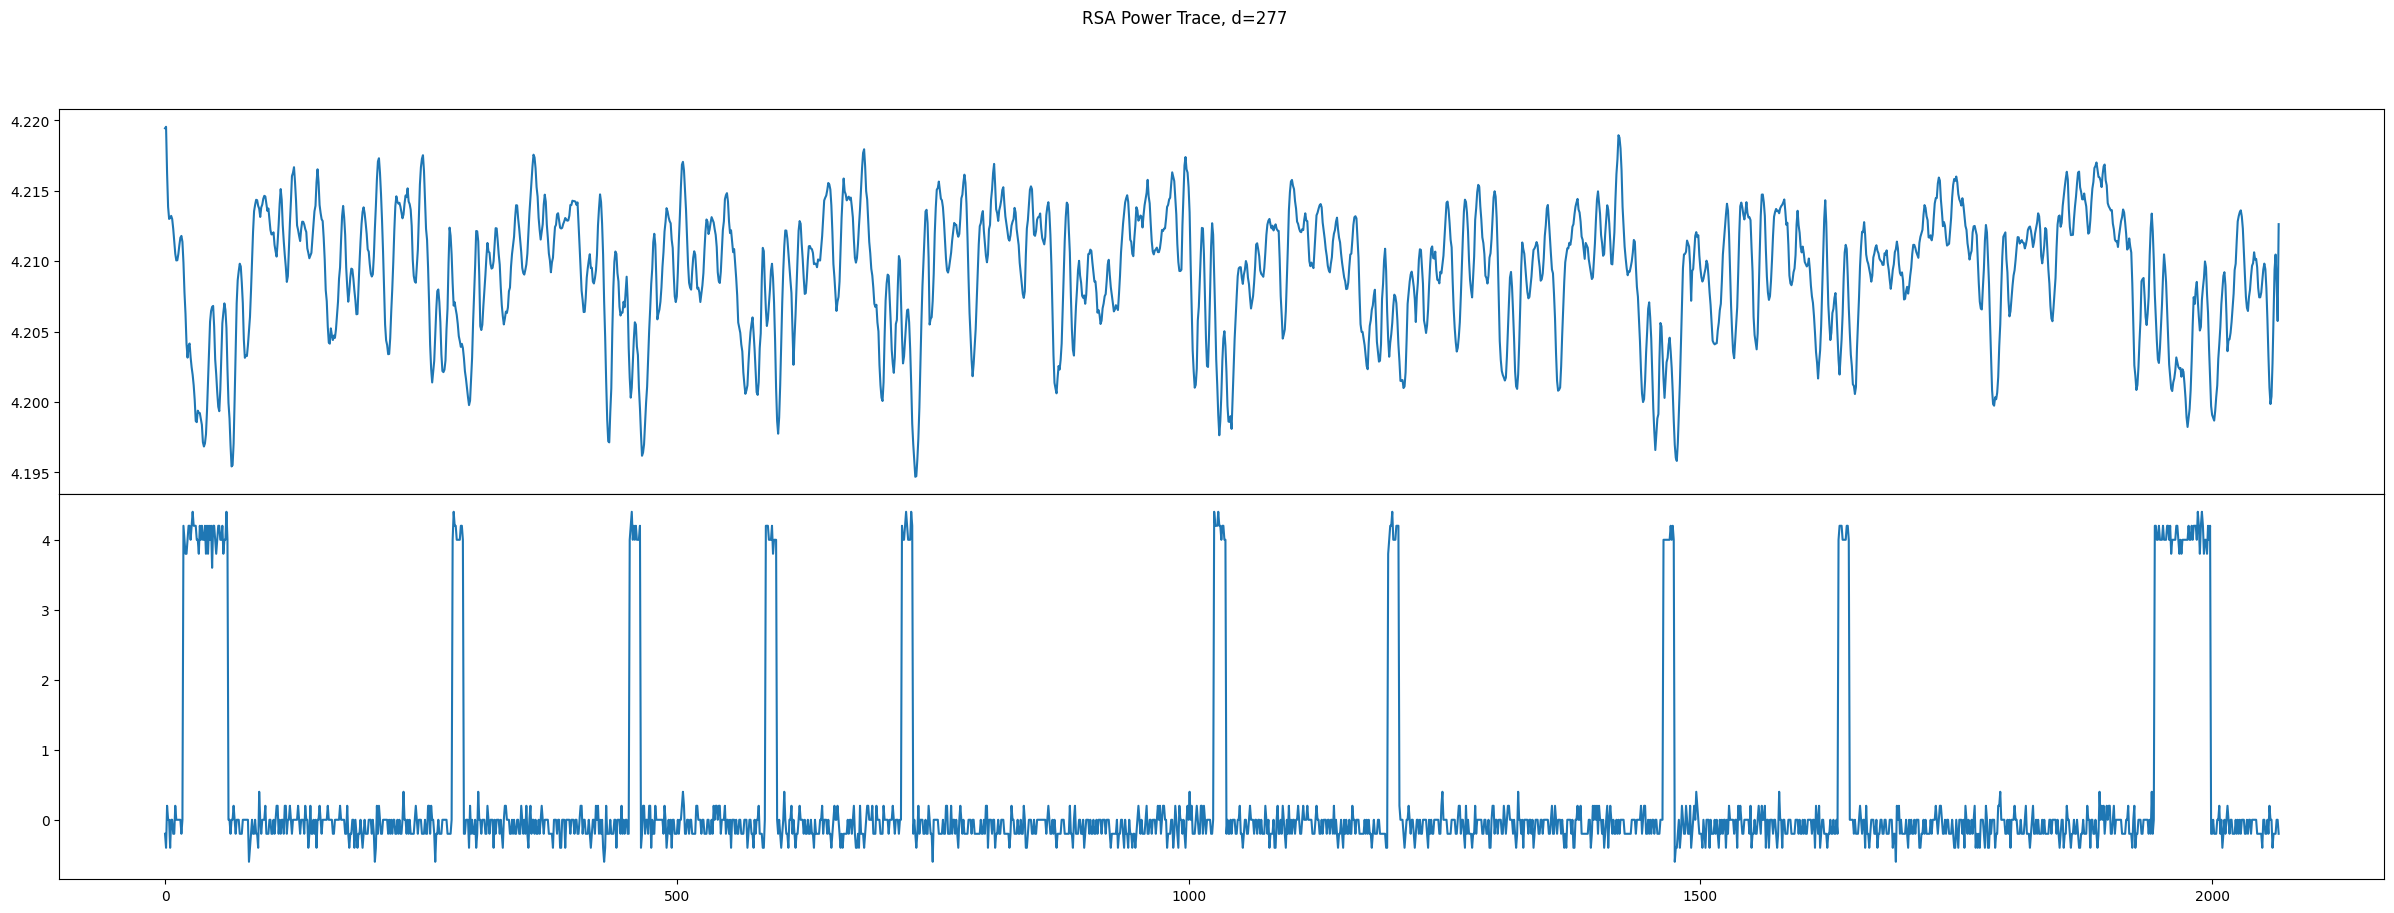

In [9]:
df_timing_voltage = df_timing_trace_clean['Voltage']


df_power_trace_voltage_filtered = scipy.signal.savgol_filter(df_power_trace_clean['Voltage'], 35, 10)

# Plotting the graph, sharing an x-axis
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
fig.suptitle('RSA Power Trace, d=277')
axs[0].plot(df_power_trace_voltage_filtered)
axs[1].plot(df_timing_voltage)

In [10]:
arr = np.array(df_power_trace_voltage_filtered)
arr = np.sort(arr)
arr[0:20]

array([4.19469334, 4.19473591, 4.19542664, 4.19551501, 4.19581711,
       4.195837  , 4.19591235, 4.19603163, 4.19618451, 4.19640387,
       4.19659503, 4.19684394, 4.1969117 , 4.19695875, 4.19699849,
       4.19699967, 4.19704735, 4.19705949, 4.19712059, 4.19713685])

In [11]:
minvalue = 4.19469334 + 0.008
signatures = []

limit = 175 #comment this out

first = 0;
start = first;
for i in range(1, len(df_power_trace_voltage_filtered)):
    if df_power_trace_voltage_filtered[i] < minvalue:

        #comment this if statement out to see distribution
        #if below limit, likely will be a anomaly point or the segment is not completed yet.
        if i - start < limit:
            continue

        signatures.append(df_power_trace_voltage_filtered[start : i])
        start = i

for i in range(len(signatures)):
    print(len(signatures[i]))

260
175
179
175
216
202
235
194
288


In [12]:
decryption_key = 0
threshold = 210 #threshold to determine bit 0 or 1

for i in range(len(signatures)):

    decryption_key = decryption_key << 1
    if (len(signatures[i]) > threshold):
        decryption_key = decryption_key | 1

print(f"Decryption key: {decryption_key}")

Decryption key: 277


## Comparisons

### Power trace for d = 7
- Minimum Threshold = 300 (points on the graph)
- Timing between points = 0.0000002
- 300 x 0.0000002 = 0.00006
    
### Power trace for d=277
- Minimum Threshold = 150 (points on the graph)
- Timing between points = 4x10^-7
- 150 x (4x10^-7) = 0.00007

With these 2 results, we can also deduce that the time needed for one cycle of modulo exponentiation should be minimally 0.00006s to 0.00007s.

Any further traces can then utilize this minimum threshold.

